In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [77]:
data = pd.read_csv(r'Telco_customer_churn.csv')

In [78]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [79]:
data = data[['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']]

In [72]:
data['TotalCharges'] = data['TotalCharges'].str.replace(' ', '')

### Dummificando variables y limpiando caracteres extraños de TotalCharges

In [81]:
data['gender'] = data['gender'].map({'Male': 1, 'Female': 0})
data['Partner'] = data['Partner'].map({'Yes': 1, 'No': 0})
data['Dependents'] = data['Dependents'].map({'Yes': 1, 'No': 0})
data['PhoneService'] = data['PhoneService'].map({'Yes': 1, 'No': 0})
data['PaperlessBilling'] = data['PaperlessBilling'].map({'Yes': 1, 'No': 0})
data['MultipleLines'] = data['MultipleLines'].map({'Yes': 1, 'No': 0, 'No phone service': 2})
data['OnlineSecurity'] = data['OnlineSecurity'].map({'Yes': 1, 'No': 0, 'No internet service': 2})
data['OnlineBackup'] = data['OnlineBackup'].map({'Yes': 1, 'No': 0, 'No internet service': 2})
data['DeviceProtection'] = data['DeviceProtection'].map({'Yes': 1, 'No': 0, 'No internet service': 2})
data['TechSupport'] = data['TechSupport'].map({'Yes': 1, 'No': 0, 'No internet service': 2})
data['StreamingTV'] = data['StreamingTV'].map({'Yes': 1, 'No': 0, 'No internet service': 2})
data['StreamingMovies'] = data['StreamingMovies'].map({'Yes': 1, 'No': 0, 'No internet service': 2})
data['Contract'] = data['Contract'].map({'Month-to-month': 0, 'Two year':1, 'One year': 2})
data['PaymentMethod'] = data['PaymentMethod'].map({'Electronic check': 0, 'Mailed check':1,
                                                    'Bank transfer (automatic)': 2, 'Credit card (automatic)':3})
data['InternetService'] = data['InternetService'].map({'Fiber optic': 0, 'DSL':1, 'No': 2})
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   int64  
 7   InternetService   7043 non-null   int64  
 8   OnlineSecurity    7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  DeviceProtection  7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
 12  StreamingTV       7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  Contract          7043 non-null   int64  
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null   int64  


In [83]:
data['Churn'].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [84]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,2,1,0,1,0,0,0,0,0,1,0,29.85,29.85,0
1,1,0,0,0,34,1,0,1,1,0,1,0,0,0,2,0,1,56.95,1889.50,0
2,1,0,0,0,2,1,0,1,1,1,0,0,0,0,0,1,1,53.85,108.15,1
3,1,0,0,0,45,0,2,1,1,0,1,1,0,0,2,0,2,42.30,1840.75,0
4,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,1,0,70.70,151.65,1


### Normalización y split

In [86]:
X = data.drop('Churn', axis=1)
y = data['Churn']

# Normalizando la data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [87]:
xgboost = XGBClassifier()

### Grid search

In [105]:
param_grid = {
    'n_estimators': [70, 140, 170],
    'learning_rate': [0.001, 0.01, 0.05],
    'subsample': [0.4, 0.7, 0.8],
    'max_depth': [4,5,6]
}

In [106]:
grid_search = GridSearchCV(estimator=xgboost, param_grid=param_grid, 
                           scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.05],
                         'max_depth': [4, 5, 6], 'n_estimators': [70, 140, 170],
                         'subsample': [0.4, 0.7, 0.8]},
             scoring='roc_auc', verbose=1)

Mejores parametros:  {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 70, 'subsample': 0.4}
Accuracy:  0.81
[[941  95]
 [173 200]]


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

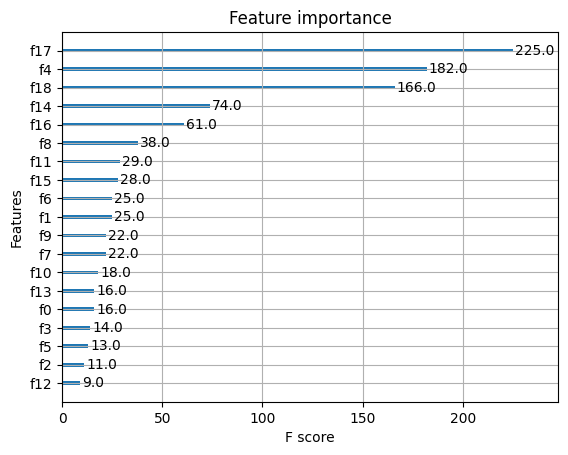

In [107]:
print("Mejores parametros: ", grid_search.best_params_)

# Predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model
accuracy = round(accuracy_score(y_test, y_pred),2)
print("Accuracy: ", accuracy)

print(confusion_matrix(y_test, y_pred))

plot_importance(grid_search.best_estimator_)

### Random search

In [94]:
random_search = RandomizedSearchCV(estimator=xgboost, param_distributions=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_iter=20)

# Fit
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=20,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.05],
                                        'max_depth': [4, 5, 6],
                                        'n_estimators': [70, 140, 170],
                                        'subsample': [0.4, 0.7, 0.8]},
                   scoring='accuracy', verbose=1)

In [95]:
print("Mejores parametros: ", random_search.best_params_)

# Predictions on the test set
y_pred = random_search.best_estimator_.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
print(confusion_matrix(y_test, y_pred))

Mejores parametros:  {'subsample': 0.4, 'n_estimators': 170, 'max_depth': 5, 'learning_rate': 0.01}
Accuracy:  0.8048261178140526
[[966  70]
 [205 168]]
